In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Import the Dataset
The dataset is the collection of over 150,000 online comments which is labelled by human based on its harmful. There are 5 labels including **toxic**, **severe_toxic**, **obscene**, **threat**, **insult** and **identity_hate**. The data contains offensive and hateful language; however, it is a good fit to AI learning and hateful speech detection. As TikTok is an interactive platform, the dataset does wonder for developing an AI model that prevents negative comments and improving the safety when online.


The data source [link](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge/data)


In [ ]:
path = "drive/MyDrive/dataset/train.csv"

df = pd.read_csv(path, sep=",")
df = df.drop(columns=["id"])    # remove comment_id

df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Cleaning

After importing the dataset to the dataframe using pandas, the text is cleaned by removing unnecessary substring unrelated to the semantic meaning of the sentence.


*   Removing internal URL: Checkout this link https://abc.com -> Check out this link
*   Removing non-alphabetic characters: Hey man, I'm really not trying to edit war. -> Hey man Im really not trying to edit war
*   Removing newline: Explanation\nWhy the edits -> Explanation Why the edits
*   Removeing 3 consecutive substring: a aa aaa aaaa bbbbb -> a aa aaa bbb
*   Lowercase and strip the sentence

We also expand the decontraction of the text; for example: won't -> will not, is'nt -> is not, etc.


In [ ]:
def decontracted(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

def clean_text(text):
  text = re.sub(r'http\S+', '', text)             # remove URL
  text = re.sub(r'[^a-zA-Z\s]', '', text)         # remove non-alphabetic chars
  text = re.sub('\s+', ' ', text)                 # remove new line and space (\n, \t)
  text = re.sub(r'((\w)\2{3,})', r'\2\2\2', text) # remove consecutive sequence with len > 3
  text = text.lower().strip()
  return text

# Test cases
assert clean_text("Checkout this link https://abc.com") == "checkout this link"
assert clean_text("Hey man, I'm really not trying to edit war.") == "hey man im really not trying to edit war"
assert clean_text("Explanation\nWhy the edits") == "explanation why the edits"
assert clean_text("  Hello   World!  ") == "hello world"
assert clean_text("Hey, check this out: https://example.com. Explanation\nWhy the edits!") == "hey check this out explanation why the edits"
assert clean_text("a aa aaaa aaaaaa bbbbb ccccc") == "a aa aaa aaa bbb ccc"
assert decontracted("I won't he's she isn't") == "I will not he is she is not"

df["comment_text"] = df["comment_text"].apply(decontracted)
df["comment_text"] = df["comment_text"].apply(clean_text)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour i am se...,0,0,0,0,0,0
2,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [ ]:
# remove empty text
df = df.drop(df[df.comment_text == ''].index)
df = df.reset_index(drop=True)

len(df[df['comment_text'] == ''])

0

Next, we will have a look at some hateful comments in which it is labeled toxic or threat. Notice that a comment can have multiple toxicities (For example, a comment is either toxic or insult at the same time).

**Be aware with vulgar language*

In [ ]:
df[df.toxic > 0].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,cocksucker before you piss around on my work,1,1,1,0,1,0
12,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0
16,bye do not look come or think of comming back ...,1,0,0,0,0,0
42,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0


In [ ]:
df[df.threat > 0].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,hi i am back again last warning stop undoing m...,1,0,0,1,0,0
176,i think that your a fagget get a oife and burn...,1,0,1,1,1,1
600,i am also a sock puppet of this accountsuprise...,1,0,0,1,0,0
802,fuck you smith please have me notified when yo...,1,0,1,1,1,0
1017,wouldnt be the first time bitch fuck you ill f...,1,1,1,1,1,1


We add a new column to the dataframe called "hateful" in which defines the comment text is hateful or normal. A comment is normal if all of the labels is 0, is hateful otherwise. The reason we add new binary column is to serve the binary classification model as well as to plot some data insights.

In [ ]:
df["hateful"] = df.apply(
    lambda r: 1 if (r.toxic or r.severe_toxic or
                    r.obscene or r.threat or
                    r.insult or r.identity_hate) else 0, axis=1)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hateful
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour i am se...,0,0,0,0,0,0,0
2,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0
3,more i can not make any real suggestions on im...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


# Dataset Insights

This section displays the visualization of the dataset, giving us the insight into how data is distributed. The graph below demonstrates the distribution of total words (with duplicate) and unique words for every single comment. From the observation, we can see it is heavily right-skewed with a large number of short texts (<= 200 words). There are longer comments which is considered outlier. As a result, based on the graph, we will define the range of **sequence_length** between 200 and 300, which is a parameter passing to Text Vectorization layer.

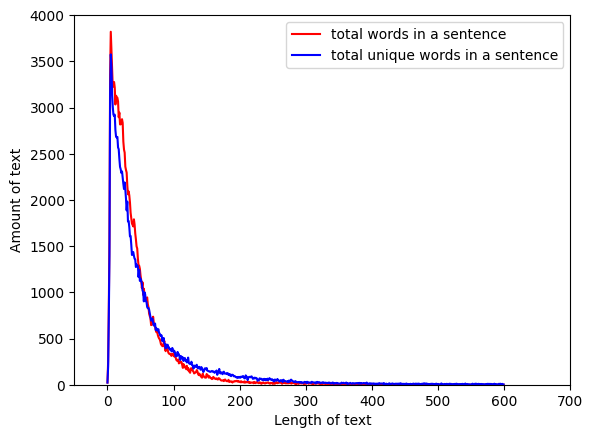

In [ ]:
total_words = [0] * 1500          # count sequence length
total_unique_words = [0] * 1500   # count unique sequence length

for text in df['comment_text']:
  text = text.split()
  total_words[len(text)] += 1
  total_unique_words[len(set(text))] += 1

# plotting
plt.plot(total_unique_words[:600], color='red')
plt.plot(total_words[:600], color='blue')
plt.xlim(-50, 700)
plt.ylim(0, 4000)
plt.xlabel("Length of text")
plt.ylabel("Amount of text")
plt.legend(["total words in a sentence", "total unique words in a sentence"])
plt.show()

The bar chart and pie chart outlines the number of comments for various categories. There is a significant imbalance between hateful comment and normal one. More specificly, the negative comment only accounts for 10% of the total dataset. Also, the severe toxic, threat and identity hate comments are extremely poor. In later section, we will resample the dataset to make it balance ready to feed into the training model.

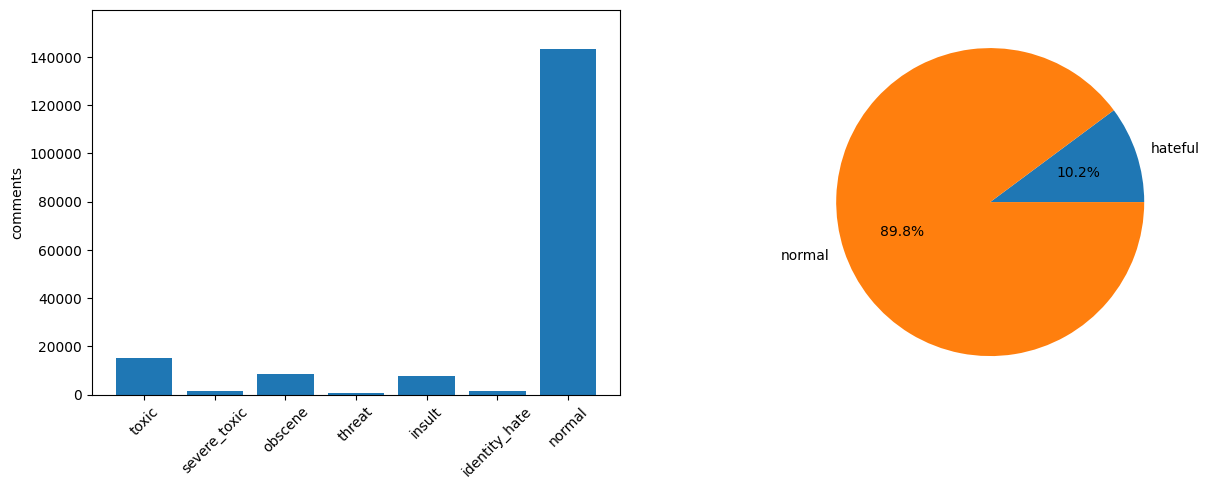

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'normal']
count = [
    len(df[df.toxic > 0]),
    len(df[df.severe_toxic > 0]),
    len(df[df.obscene > 0]),
    len(df[df.threat > 0]),
    len(df[df.insult > 0]),
    len(df[df.identity_hate > 0]),
    len(df[df.hateful == 0])
]

binary_labels = ['hateful', 'normal']
binary_count = [len(df[df.hateful == 1]), len(df[df.hateful == 0])]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, count)
plt.xticks(rotation=45)
plt.ylim(0, len(df))
plt.ylabel('comments')

plt.subplot(1, 2, 2)
plt.pie(binary_count, labels=binary_labels, autopct='%1.1f%%')

plt.show()

# Resample Binary Dataset

To make data balance, we use **imblearn** library to generate more samples so that the amount of hateful and normal comments are equal.


In [ ]:
data, target = df[df.columns[:1]].values, df[df.columns[-1]].values

over = RandomOverSampler()
data, target = over.fit_resample(data, target)

resampled_dataset = np.hstack((data, np.reshape(target, (-1, 1))))
binary_df = pd.DataFrame(resampled_dataset, columns=['comment_text', 'hateful'])
binary_df = binary_df.sample(frac=1).reset_index(drop=True)

binary_df.head()

,comment_text,hateful
0,was taken from britannica and columbia encyclo...,0
1,i think i got blocked for a bad reason as show...,1
2,go ahead make my day go ahead and block me ada...,1
3,request for arbitrationcoolkatt based on your ...,0
4,you are nothing more than a malignant cancer o...,1


Below is the visualized graph of new distribution after resampling.

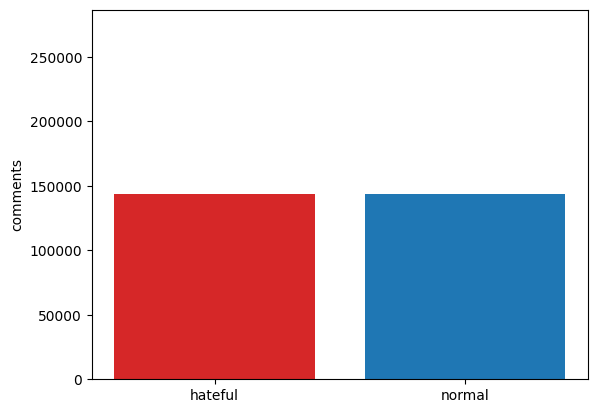

In [ ]:
labels = ['hateful', 'normal']
count = [
    len(binary_df[binary_df.hateful == 1]),
    len(binary_df[binary_df.hateful == 0])
]

plt.bar(labels, count, color=['tab:red', 'tab:blue'])
plt.ylim(0, len(binary_df))
plt.ylabel('comments')

plt.show()

# Resample Multilabel Dataset

Unfortunately, **imblearn** library doesn't support multilabel dataset. We will use the same method as with binary resampling but before that, we duplicate more comment of the minority which is labeled with severe_toxic, threat, identity_hate.

In [ ]:
duplicate_df = df

duplicate = []
duplicate.extend([duplicate_df[duplicate_df['severe_toxic'] > 0]] * 10)
duplicate.extend([duplicate_df[duplicate_df['threat'] > 0]] * 30)
duplicate.extend([duplicate_df[duplicate_df['identity_hate'] > 0]] * 10)

duplicate_df = pd.concat([duplicate_df] + duplicate).reset_index(drop=True)

duplicate_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hateful
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


We will use the same function as previous to resample the dataset. Notice that the new dataframe has 7 labels, ready for training.

In [ ]:
data, target = duplicate_df[duplicate_df.columns[:-1]].values, duplicate_df[duplicate_df.columns[-1]].values

over = RandomOverSampler()
data, target = over.fit_resample(data, target)

sampled_dataset = np.hstack((data, np.reshape(target, (-1, 1))))
multilabel_df = pd.DataFrame(sampled_dataset, columns=['comment_text','harmful', 'severe',
                                                       'obscene', 'threat', 'insult',
                                                       'discriminate', 'hateful'])

# Drop hateful and add normal speech column
multilabel_df['normal'] = multilabel_df.apply(lambda r: 0 if r.hateful else 1, axis=1)
multilabel_df.drop(columns=['hateful'], inplace=True)
multilabel_df = multilabel_df.sample(frac=1).reset_index(drop=True)

multilabel_df.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


The bar chart below demonstrates the distribution of 7 categories after resampling

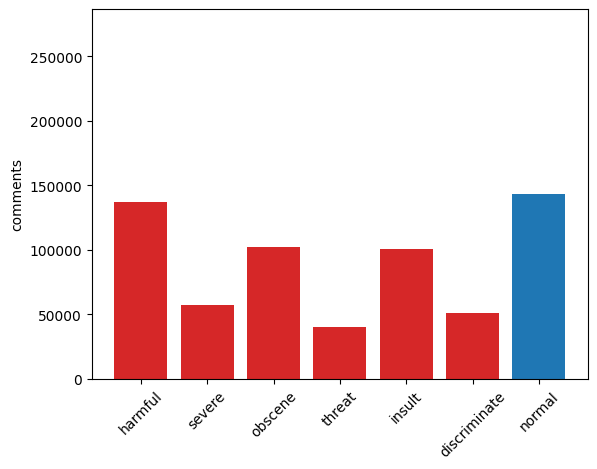

In [ ]:
labels = ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']
colors = ['tab:red'] * 6 + ['tab:blue']
count = [
    len(multilabel_df[multilabel_df.harmful > 0]),
    len(multilabel_df[multilabel_df.severe > 0]),
    len(multilabel_df[multilabel_df.obscene > 0]),
    len(multilabel_df[multilabel_df.threat > 0]),
    len(multilabel_df[multilabel_df.insult > 0]),
    len(multilabel_df[multilabel_df.discriminate > 0]),
    len(multilabel_df[multilabel_df.normal > 0])
]

plt.bar(labels, count, color=colors)
plt.xticks(rotation=45)
plt.ylim(0, len(multilabel_df))
plt.ylabel('comments')

plt.show()

# Export the data ready for training

After being cleanned, shuffled and resamped, the dataset now is exporting to new file that is ready to feed into a binary classification model.

In [ ]:
binary_df.to_csv('drive/MyDrive/dataset/binary_comment_dataset.csv', encoding='utf-8', index=False)

In [ ]:
multilabel_df.to_csv('drive/MyDrive/dataset/multilabel_comment_dataset.csv', encoding='utf-8', index=False)